In [1]:
import pandas as pd
import numpy as np
import os
import json
import cv2
import random
import sklearn
import pydot
import tqdm
import datetime

from matplotlib import image as mpimg
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import yaml
import torch
from pathlib import Path
import random

import ultralytics
from ultralytics import YOLO

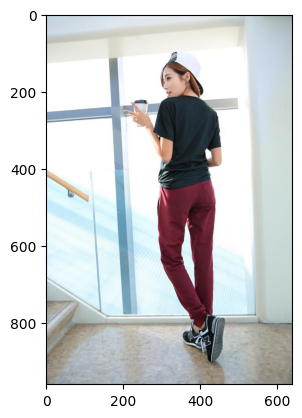

In [2]:
#Test if disk F: can be read
#If not please disconnect then reconnect Disk F:
img_id = "001284"

image = mpimg.imread(f"D:/Benji/deepfashion2_dataset/train/image/{img_id}.jpg")
plt.imshow(image)
plt.show()

In [3]:
# Initialize Directory
train_dir = "D:/Benji/deepfashion2_dataset_filter/train/pos/img"
train_label = "D:/Benji/deepfashion2_dataset_filter/train/pos/label"
val_dir = "D:/Benji/deepfashion2_dataset_filter/val/img"
val_label = "D:/Benji/deepfashion2_dataset_filter/val/label"
test_dir = "D:/Benji/deepfashion2_dataset_filter/test/"

In [4]:
ultralytics.checks()

Ultralytics YOLOv8.0.203  Python-3.11.3 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11264MiB)
Setup complete  (12 CPUs, 31.9 GB RAM, 296.5/446.5 GB disk)


In [6]:
model = YOLO('yolov8n.pt')
results = model.train(data='D:/Benji/yaml/deepfashion2.yaml', epochs=50, batch=32, patience=25)

New https://pypi.org/project/ultralytics/8.0.208 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.203  Python-3.11.3 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11264MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=D:/Benji/yaml/deepfashion2.yaml, epochs=50, patience=25, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=Fal

      27/50      4.16G     0.7319     0.8019      1.106        103        640: 100%|██████████| 4049/4049 [19:04<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 503/503 [02:
                   all      32153      32153      0.467        0.6      0.508      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/50      4.16G     0.7307     0.7977      1.104         96        640: 100%|██████████| 4049/4049 [19:05<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 503/503 [02:
                   all      32153      32153      0.462      0.606      0.508      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/50      4.16G     0.7279     0.7928      1.102         78        640: 100%|██████████| 4049/4049 [19:05<00:00,
                 Class     Images  Instances      Box(P         

In [13]:
class SimpleClass:
    """Ultralytics SimpleClass is a base class providing helpful string representation, error reporting, and attribute
    access methods for easier debugging and usage.
    """

    def __str__(self):
        """Return a human-readable string representation of the object."""
        attr = []
        for a in dir(self):
            v = getattr(self, a)
            if not callable(v) and not a.startswith('_'):
                if isinstance(v, SimpleClass):
                    # Display only the module and class name for subclasses
                    s = f'{a}: {v.__module__}.{v.__class__.__name__} object'
                else:
                    s = f'{a}: {repr(v)}'
                attr.append(s)
        return f'{self.__module__}.{self.__class__.__name__} object with attributes:\n\n' + '\n'.join(attr)

    def __repr__(self):
        """Return a machine-readable string representation of the object."""
        return self.__str__()

    def __getattr__(self, attr):
        """Custom attribute access error message with helpful information."""
        name = self.__class__.__name__
        raise AttributeError(f"'{name}' object has no attribute '{attr}'. See valid attributes below.\n{self.__doc__}")


class Metric(SimpleClass):

    def __init__(self) -> None:
        """Initializes a Metric instance for computing evaluation metrics for the YOLOv8 model."""
        self.p = []  # (nc, )
        self.r = []  # (nc, )
        self.f1 = []  # (nc, )
        self.all_ap = []  # (nc, 10)
        self.ap_class_index = []  # (nc, )
        self.nc = 0

    @property
    def ap50(self):
        return self.all_ap[:, 0] if len(self.all_ap) else []

    @property
    def ap(self):
        return self.all_ap.mean(1) if len(self.all_ap) else []

    @property
    def mp(self):
        return self.p.mean() if len(self.p) else 0.0

    @property
    def mr(self):
        return self.r.mean() if len(self.r) else 0.0

    @property
    def map50(self):
        return self.all_ap[:, 0].mean() if len(self.all_ap) else 0.0

    @property
    def map75(self):
        return self.all_ap[:, 5].mean() if len(self.all_ap) else 0.0

    @property
    def map(self):
        return self.all_ap.mean() if len(self.all_ap) else 0.0

    def mean_results(self):
        """Mean of results, return mp, mr, map50, map."""
        return [self.mp, self.mr, self.map50, self.map]

    def class_result(self, i):
        """Class-aware result, return p[i], r[i], ap50[i], ap[i]."""
        return self.p[i], self.r[i], self.ap50[i], self.ap[i]

    @property
    def maps(self):
        """MAP of each class."""
        maps = np.zeros(self.nc) + self.map
        for i, c in enumerate(self.ap_class_index):
            maps[c] = self.ap[i]
        return maps

    def fitness(self):
        """Model fitness as a weighted combination of metrics."""
        w = [0.0, 0.0, 0.1, 0.9]  # weights for [P, R, mAP@0.5, mAP@0.5:0.95]
        return (np.array(self.mean_results()) * w).sum()

    def update(self, results):
        (self.p, self.r, self.f1, self.all_ap, self.ap_class_index, self.p_curve, self.r_curve, self.f1_curve, self.px,
         self.prec_values) = results

    @property
    def curves(self):
        """Returns a list of curves for accessing specific metrics curves."""
        return []

    @property
    def curves_results(self):
        """Returns a list of curves for accessing specific metrics curves."""
        return [[self.px, self.prec_values, 'Recall', 'Precision'], [self.px, self.f1_curve, 'Confidence', 'F1'],
                [self.px, self.p_curve, 'Confidence', 'Precision'], [self.px, self.r_curve, 'Confidence', 'Recall']]

NameError: name 'self' is not defined

AttributeError: type object 'Metric' has no attribute 'f1'